# Group Analysis: FOOOFed EEG Analysis: Rest

Examine the results of parameterizing spectra for resting state EEG data, and compare results between `YNG` and `OLD` subject groups.

This notebook does the analyses and creates the plots for Figure 5.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
from os import listdir
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, pearsonr, normaltest

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_fg
from fooof.core.funcs import expo_nk_function
from fooof.sim.utils import set_random_seed

In [3]:
%load_ext autoreload
%autoreload 2

# Import custom code for this analysis
import sys
sys.path.append('../code')

from plts import *
from utils import *
from analysis import *

# Settings

In [4]:
# Import general settings
from settings import YNG_INDS, OLD_INDS
from settings import BANDS, RESULTS_PATH

In [5]:
# Set the random seed
set_random_seed(303)

In [6]:
# Set whether to drop outlier subjects, in terms of FOOOF Goodness-of-Fit metrics
drop_outliers = False

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

# Set FOOOF peak params label
peak_label = 'peak_params' # 'peak_params', 'gaussian_params'

# Set channel indices to use
ch_ind_oz = 28  # Channel Oz (28)
ch_ind_cz = 47  # Channel Cz (47)

# Wether to save out plots or not
SAVE_FIG = True

In [7]:
# Check the subject numbers
print('Number of young subjects:  ', len(YNG_INDS))
print('Number of  old  subjects:  ', len(OLD_INDS))

Number of young subjects:   17
Number of  old  subjects:   14


### Load FOOOF Data

In [8]:
# Set the data folder to run
data_folder = 'FOOOF'

In [9]:
# Get files
files = listdir(pjoin(RESULTS_PATH, data_folder))
files = [file for file in files if 'RAW' in file]
files.sort()

In [10]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(RESULTS_PATH, data_folder))
    fgs.append(fg.copy())

### Extract FOOOF Data

In [11]:
# Extract alphas from each subject
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    alphas[ind, :] = get_band_peak_fg(fg, BANDS.alpha, attribute=peak_label)[ch_ind_oz, :]

In [12]:
# Extract aperiodic parameters for each subject
aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind_cz]
offs = aps[:, 0]
exps = aps[:, 1]

In [13]:
# Extract error & R^2 from FOOOF fits
errs = []; r2s = []
for fg in fgs:
    errs.append(fg.get_results()[ch_ind_oz].error)
    r2s.append(fg.get_results()[ch_ind_oz].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

### Check For Outliers

This check and drop procedure finds & drops subjects for which the FOOOF goodness-of-fit metrics are statistical outliers, indicating poor fits. 

In [14]:
# Settings for outlier check
std_thresh = 2.5

In [15]:
# Check for outliers using FOOOF Goodness of Fit metrics
err_outliers = check_outliers(errs, std_thresh)
std_outliers = check_outliers(r2s, std_thresh)

In [16]:
# Check if the same outliers are detected for each GoF measure
print(err_outliers)
print(std_outliers)

[21]
[21]


In [17]:
# Combine outlier list across GoF metrics
bad_inds = set(err_outliers + std_outliers)

In [18]:
# Drop outlier GoF values
if drop_outliers:
    print('DROPPING {} OUTLIER'.format(len(bad_inds)))
    for bad_ind in bad_inds:
        print('\tRemoving index # ', bad_ind)
        try:
            YNG_INDS.remove(bad_ind)
            OLD_INDS.remove(bad_ind)
        except: pass

### Dataset Checks

In [19]:
print('Total Number of analyzed subjects: \t{}'.format(
    len(YNG_INDS) + len(OLD_INDS)))
print('Degrees of Freedom for Group Tests: \t{}'.format(
    len(YNG_INDS) + len(OLD_INDS) - 2))

Total Number of analyzed subjects: 	31
Degrees of Freedom for Group Tests: 	29


In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for label, inds in zip(['YNG', 'OLD'], [YNG_INDS, OLD_INDS]):
        print('\n' + label)
        print_stat('Exps', *normaltest(exps[inds]))
        print_stat('Offs', *normaltest(offs[inds]))
        print_stat('Al-CF', *normaltest(alphas[inds, 0]))
        print_stat('Al-PW', *normaltest(alphas[inds, 1]))
        print_stat('Al-BW', *normaltest(alphas[inds, 2]))


YNG
Exps: 	  0.4754 	 0.7884
Offs: 	  17.2250 	 0.0002
Al-CF: 	  5.6496 	 0.0593
Al-PW: 	  1.0557 	 0.5899
Al-BW: 	  2.6249 	 0.2692

OLD
Exps: 	  1.5515 	 0.4604
Offs: 	  2.5306 	 0.2822
Al-CF: 	  3.0237 	 0.2205
Al-PW: 	  6.6606 	 0.0358
Al-BW: 	  9.4391 	 0.0089


## Compare Features Between Groups

Now we will analyze and visualize spectral parameters, and compare them between groups.

Note that the `plot_comp_scatter` plots apply some random jitter to the x-axis, to aid with visualization. 

Because of this re-plotting is not guaranteed to re-create the literal exact same plot, but any differences in x-jitter are meaningless. 

## Aperiodic Comparisons

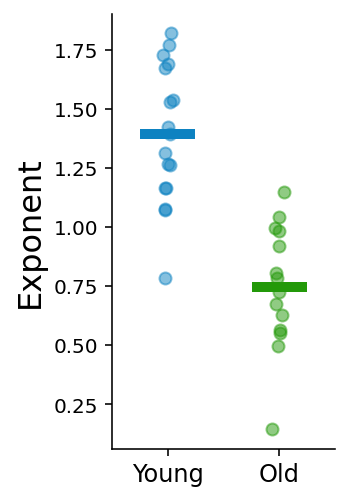

In [21]:
# Plot exponent comparison
plot_comp_scatter(exps, 'Exponent', save_fig=SAVE_FIG, save_name='exponents')

In [22]:
# Statistically test exponent difference
print_stat('Exponent t-test\t', *ttest_ind(exps[YNG_INDS], exps[OLD_INDS]))
print_stat('YNG / OLD means\t', np.mean(exps[YNG_INDS]), np.mean(exps[OLD_INDS]))
print_stat('YNG / OLD stds\t', np.std(exps[YNG_INDS]), np.std(exps[OLD_INDS]))
print_stat('abs / std diff\t', mean_diff(exps[YNG_INDS], exps[OLD_INDS]),
           cohens_d(exps[YNG_INDS], exps[OLD_INDS]))

Exponent t-test	: 	  6.3741 	 0.0000
YNG / OLD means	: 	  1.3925 	 0.7480
YNG / OLD stds	: 	  0.2826 	 0.2562
abs / std diff	: 	  0.6445 	 2.3113


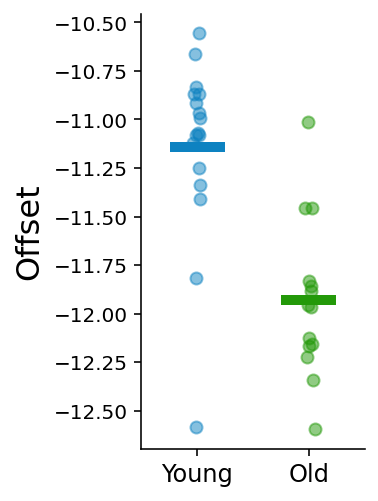

In [23]:
# Plot offset comparison
plot_comp_scatter(offs, 'Offset', save_fig=SAVE_FIG, save_name='Offsets')

In [24]:
# Statistically test offset difference
print_stat('Offset t-test\t', *ttest_ind(offs[YNG_INDS], offs[OLD_INDS]))
print_stat('YNG / OLD Means\t', np.mean(offs[YNG_INDS]), np.mean(offs[OLD_INDS]))
print_stat('YNG / OLD stds\t', np.std(offs[YNG_INDS]), np.std(offs[OLD_INDS]))
print_stat('abs / dtd diff\t', mean_diff(offs[YNG_INDS], offs[OLD_INDS]),
                               cohens_d(offs[YNG_INDS], offs[OLD_INDS]))

Offset t-test	: 	  4.9075 	 0.0000
YNG / OLD Means	: 	 -11.1419 	-11.9310
YNG / OLD stds	: 	  0.4600 	 0.3927
abs / dtd diff	: 	  0.7891 	 1.7848


## Periodic Comparisons

### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the aperiodic + the alpha peak power.

In [25]:
# Collect the aperiodic parameters for each subject
oz_aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind_oz]

In [26]:
# Calculate total alpha as the value of the aperiodic component at 
#   the alpha center frequency, plus the power of the alpha peak
tot_alphas = []
for ap, cf, pw in zip(oz_aps, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10
    #   and set alpha power to zero
    if np.isnan(cf):
        cf, pw = 10, 0
    
    # Calculate the value of aperiodic at the alpha-CF & add to the alpha-power
    tot_alphas.append(expo_nk_function(np.array([cf]), *ap)[0] + pw)
    
tot_alphas = np.array(tot_alphas)

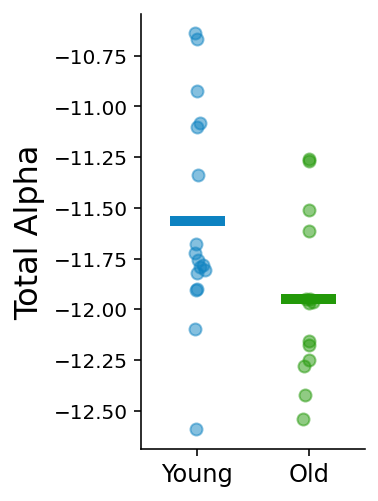

In [27]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp_scatter(tot_alphas, 'Total Alpha',
                  save_fig=SAVE_FIG, save_name='TotalAlpha')

In [28]:
# Statistically test total 'alpha' difference
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))
print_stat('YNG / OLD means\t', np.mean(tot_alphas[YNG_INDS]), np.mean(tot_alphas[OLD_INDS]))
print_stat('YNG / OLD stds\t', np.std(tot_alphas[YNG_INDS]), np.std(tot_alphas[OLD_INDS]))
print_stat('abs / std diff\t', mean_diff(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]),
                             cohens_d(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))

Total Alpha t-test: 	  2.2553 	 0.0318
YNG / OLD means	: 	 -11.5645 	-11.9510
YNG / OLD stds	: 	  0.5102 	 0.3884
abs / std diff	: 	  0.3865 	 0.8248


### Check number of extracted oscillations

In [29]:
# Get the number of oscillations on the alpha channel
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind_oz].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [30]:
# Statistically test number of peaks difference
print_stat('# of Peaks t-test', *ttest_ind(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))
print_stat('YNG / OLD means\t', np.mean(n_oscs[YNG_INDS]), np.mean(n_oscs[OLD_INDS]))
print_stat('YNG / OLD stds\t', np.std(n_oscs[YNG_INDS]), np.std(n_oscs[OLD_INDS]))
print_stat('abs / std diff\t', mean_diff(n_oscs[YNG_INDS], n_oscs[OLD_INDS]),
                                 cohens_d(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))

# of Peaks t-test: 	 -0.4513 	 0.6551
YNG / OLD means	: 	  4.1765 	 4.3571
YNG / OLD stds	: 	  1.1497 	 0.9715
abs / std diff	: 	 -0.1807 	 0.0000


### Statistically Compare Peak Parameters

In [31]:
# Check differences in alpha measures, between groups
for d_ind, label in zip([0, 1, 2], ['CF', 'PW', 'BW']):

    # Select data
    data = alphas[:, d_ind]
    yng_data = list(data[YNG_INDS][~np.isnan(data[YNG_INDS])])
    old_data = list(data[OLD_INDS][~np.isnan(data[OLD_INDS])])
    
    # Statistically compare and check average difference between groups
    print(label)
    print_stat('\tt-test', *ttest_ind(yng_data, old_data))
    print_stat('\tYNG/OLD means', np.mean(yng_data), np.mean(old_data))
    print_stat('\tYNG/OLD stds', np.std(yng_data), np.std(old_data))
    print_stat('\tabs/std diff', mean_diff(yng_data, old_data), cohens_d(yng_data, old_data))

CF
	t-test: 	  1.7575 	 0.0894
	YNG/OLD means: 	  10.5588 	 9.6298
	YNG/OLD stds: 	  1.1925 	 1.6483
	abs/std diff: 	  0.9290 	 0.6237
PW
	t-test: 	  2.2020 	 0.0358
	YNG/OLD means: 	  0.7463 	 0.4533
	YNG/OLD stds: 	  0.3837 	 0.3206
	abs/std diff: 	  0.2930 	 0.8017
BW
	t-test: 	  0.3049 	 0.7626
	YNG/OLD means: 	  1.8450 	 1.7578
	YNG/OLD stds: 	  0.6076 	 0.9232
	abs/std diff: 	  0.0872 	 0.1077


In [32]:
# Check how many subjects don't have alpha
print('Number of subjects with no alpha:')
print('\t YNG:\t', sum(np.isnan(data[YNG_INDS])))
print('\t OLD: \t', sum(np.isnan(data[OLD_INDS])))

Number of subjects with no alpha:
	 YNG:	 0
	 OLD: 	 0


### Alpha - Center Frequency

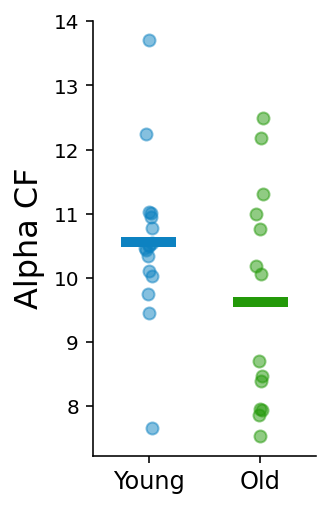

In [33]:
# Plot alpha center frequency comparison
plot_comp_scatter(alphas[:, 0], 'Alpha CF',
                  save_fig=SAVE_FIG, save_name='AlphaCF')

### Alpha - Power

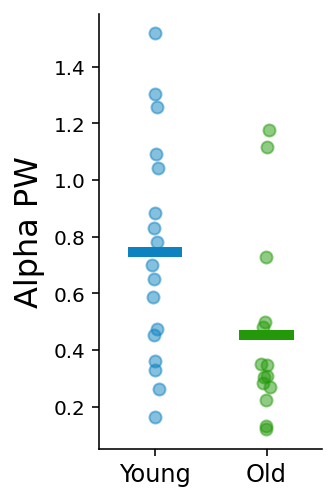

In [34]:
# Plot alpha power comparison
plot_comp_scatter(alphas[:, 1], 'Alpha PW',
                  save_fig=SAVE_FIG, save_name='AlphaPW')

### Alpha - Bandwidth

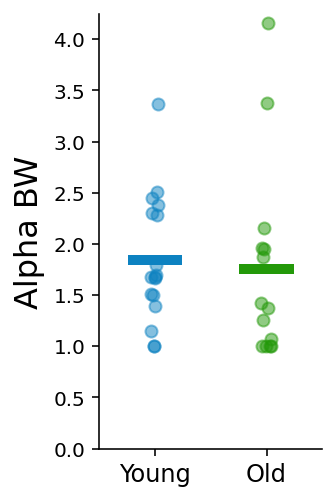

In [35]:
# Plot alpha bandwidth comparison
plot_comp_scatter(alphas[:, 2], 'Alpha BW', ylim=[0, 4.25],
                  save_fig=SAVE_FIG, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

Plot reconstructions of the alpha peaks, for each group. 

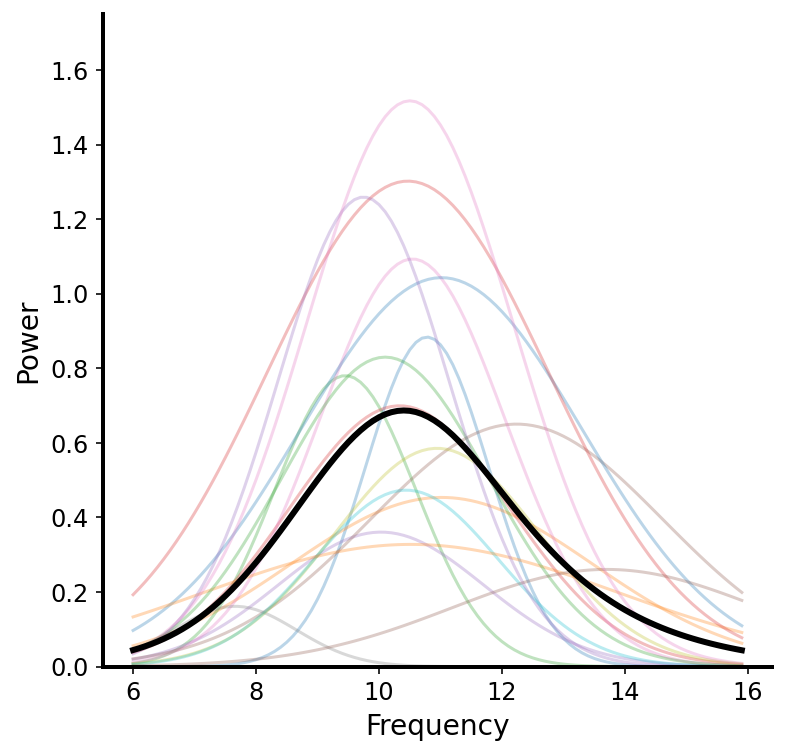

In [36]:
# Alpha peak reconstructions - YNG group
plot_oscillations(alphas[YNG_INDS, :],
                  save_fig=SAVE_FIG, save_name='YoungAlphas')

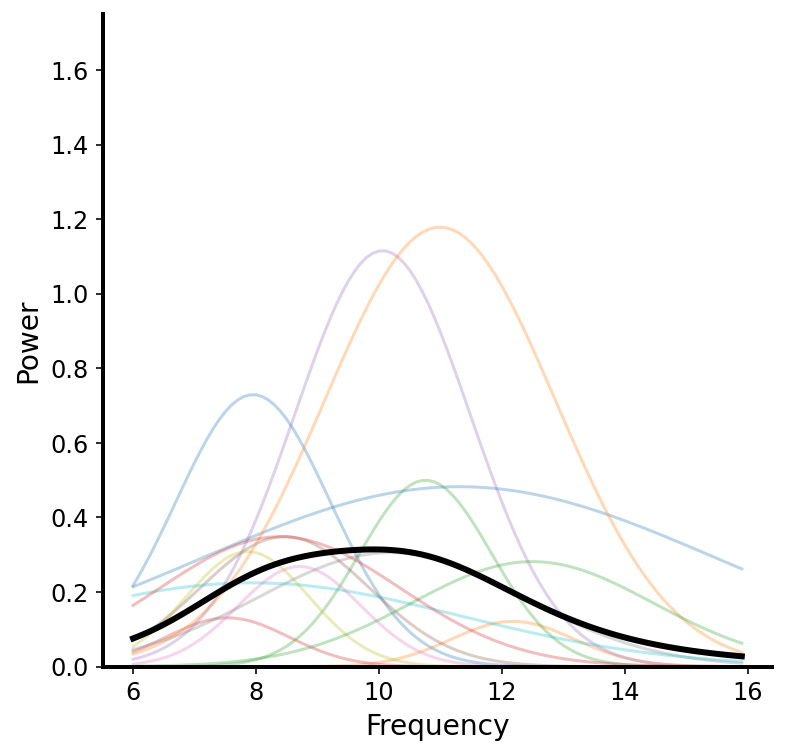

In [37]:
# Alpha peak reconstructions - OLD group
plot_oscillations(alphas[OLD_INDS, :],
                  save_fig=SAVE_FIG, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band

In this comparison, for each group, we will compare how much each individual subject's alpha peak overlaps with a canonically defined alpha (centered at 10 Hz). This can be used to estimate to what extent a canonical analysis, such as applying a 8-12 Hz bandpass filter, may miss some of the subject's alpha. 

In [38]:
# Calculate overlaps
overlaps = calc_overlaps(alphas)

In [39]:
# Check average (overall) of overlaps, and stats
print('ALL avg overlap:  {:1.4f}'.format(np.mean(np.abs(overlaps))), '\n')

print_stat('diff overlap\t', *ttest_ind(overlaps[YNG_INDS], overlaps[OLD_INDS]))
print_stat('YNG/OLD means\t', np.mean(overlaps[YNG_INDS]), np.mean(overlaps[OLD_INDS]))
print_stat('abs/std diff\t', mean_diff(overlaps[YNG_INDS], overlaps[OLD_INDS]),
                             cohens_d(overlaps[YNG_INDS], overlaps[OLD_INDS]))

ALL avg overlap:  0.7726 

diff overlap	: 	  1.9388 	 0.0623
YNG/OLD means	: 	  0.8236 	 0.7108
abs/std diff	: 	  0.1128 	 0.7050


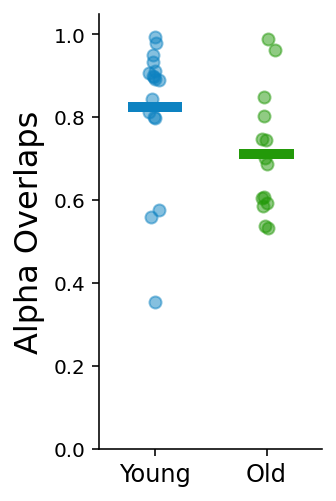

In [40]:
# Plot the overlaps of individual with canonical alpha, per group
plot_comp_scatter(overlaps, 'Alpha Overlaps', ylim=[0, 1.05],
                  save_fig=SAVE_FIG, save_name='AlphaOverlaps')

In [41]:
# Calculate the differences per subject from a 10 Hz center
overlap_diffs = alphas[:, 0] - 10
yng_overlaps = overlap_diffs[YNG_INDS]
old_overlaps = overlap_diffs[OLD_INDS]

In [42]:
# Print out average differences from 10 Hz
print('Directional Differences from 10 Hz Center, by Group:')
print('\tYNG-diff  {: 1.2f}'.format(np.mean(yng_overlaps)))
print('\tOLD-diff  {: 1.2f}'.format(np.mean(old_overlaps)))
print('\n')
print('Absolute Differences from 10 Hz Center, by Group:')
print('\tYNG-Diff  {: 1.2f}'.format(np.mean(np.abs(yng_overlaps))))
print('\tOLD-Diff  {: 1.2f}'.format(np.mean(np.abs(old_overlaps))))

Directional Differences from 10 Hz Center, by Group:
	YNG-diff   0.56
	OLD-diff  -0.37


Absolute Differences from 10 Hz Center, by Group:
	YNG-Diff   0.93
	OLD-Diff   1.51


In the above, we can see that, on average, the YNG group has alpha frequencies above 10 Hz, and the OLD group has alpha frequencies below 10 Hz. 

When compared in absolute terms, the OLD group is typically more different from a 10 Hz center frequency.

### Plot Overlap

Here we will visualize the overlaps between each groups alpha, and a canonically defined alpha. 

The canonical alpha is defined as a Gaussian centered at 10 Hz with +/- 2 Hz bandwidth. 

We can plot this for each group, and for the average deviation across all subjects.

Note: in the average, average deviation is shifted to be represented below the canonical 10 Hz. 

In [43]:
# Get the average deviation from center of 10 Hz (across groups)
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

In [44]:
# Get average deviation, per group
yng_deviation = np.mean(np.abs(alphas[YNG_INDS, 0] - 10))
old_deviation = np.mean(np.abs(alphas[OLD_INDS, 0] - 10))

In [45]:
# Check the average deviations
print('ALL :\t {:1.4f}'.format(avg_deviation))
print('YNG :\t {:1.4f}'.format(yng_deviation))
print('OLD :\t {:1.4f}'.format(old_deviation))

ALL :	 1.1902
YNG :	 0.9285
OLD :	 1.5081


In [46]:
# Set up values for overalp analysis
vals_avg = (10 - avg_deviation, 10, 2, 2)
r_avg = get_intersect(*vals_avg)
vals_yng = (10 + yng_deviation, 10, 2, 2)
r_yng = get_intersect(*vals_yng)
vals_old = (10 - old_deviation, 10, 2, 2)
r_old = get_intersect(*vals_old)

In [47]:
# Check the average overlaps
print('ALL: \t {:1.4f}'.format(get_overlap(r_avg, *vals_avg)))
print('YNG: \t {:1.4f}'.format(get_overlap(r_yng, *vals_yng)))
print('OLD: \t {:1.4f}'.format(get_overlap(r_old, *vals_old)))

ALL: 	 0.7660
YNG: 	 1.1836
OLD: 	 0.7062


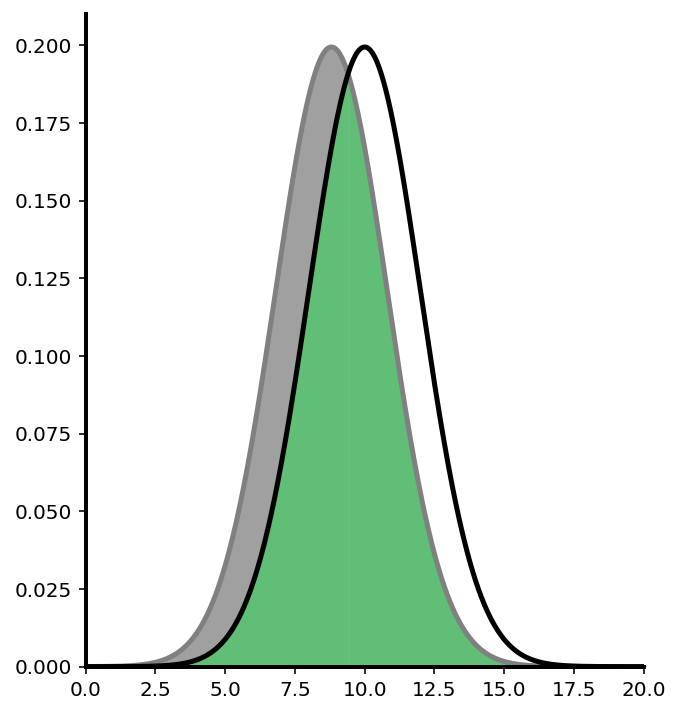

In [48]:
# Plot the overlap of canonical and average shifted alpha: ALL
plot_overlap(*vals_avg, save_fig=SAVE_FIG, save_name='CanonicalCompare-Avg')

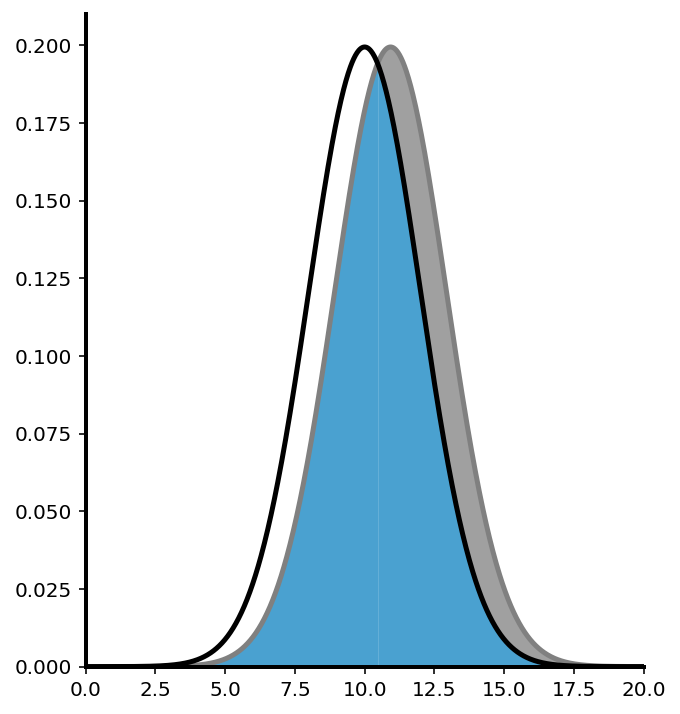

In [49]:
# Plot the overlap of canonical and average shifted alpha: YNG
plot_overlap(*vals_yng, col=YNG_COL,
             save_fig=SAVE_FIG, save_name='CanonicalCompare-Yng')

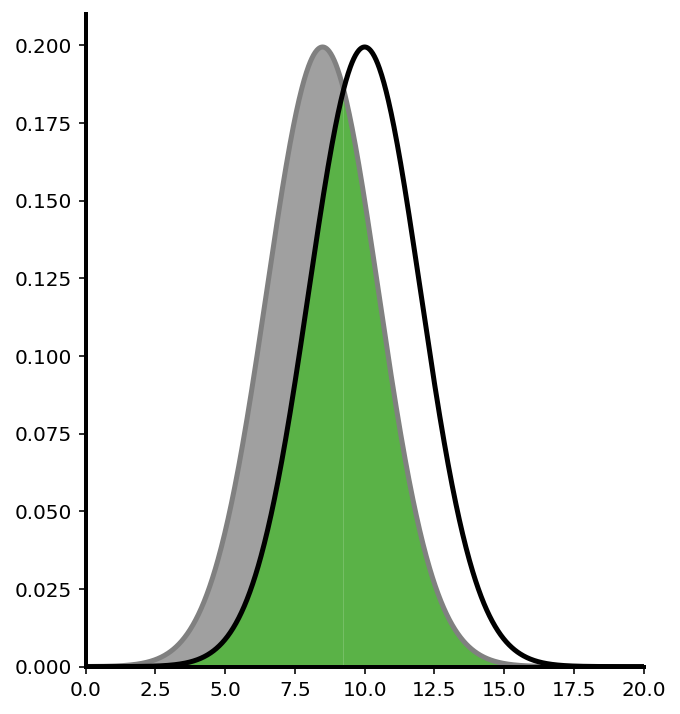

In [50]:
# Plot the overlap of canonical and average shifted alpha: OLD
plot_overlap(*vals_old, col=OLD_COL,
             save_fig=SAVE_FIG, save_name='CanonicalCompare-Old')

### Compare 'Frequency Specific' Differences from Aperiodic

Here, we plot reconstructed aperiodic components, and analyze, frequency-by-frequency, where there are significant differences in specific frequencies, that can be attributed to the aperiodic component. 

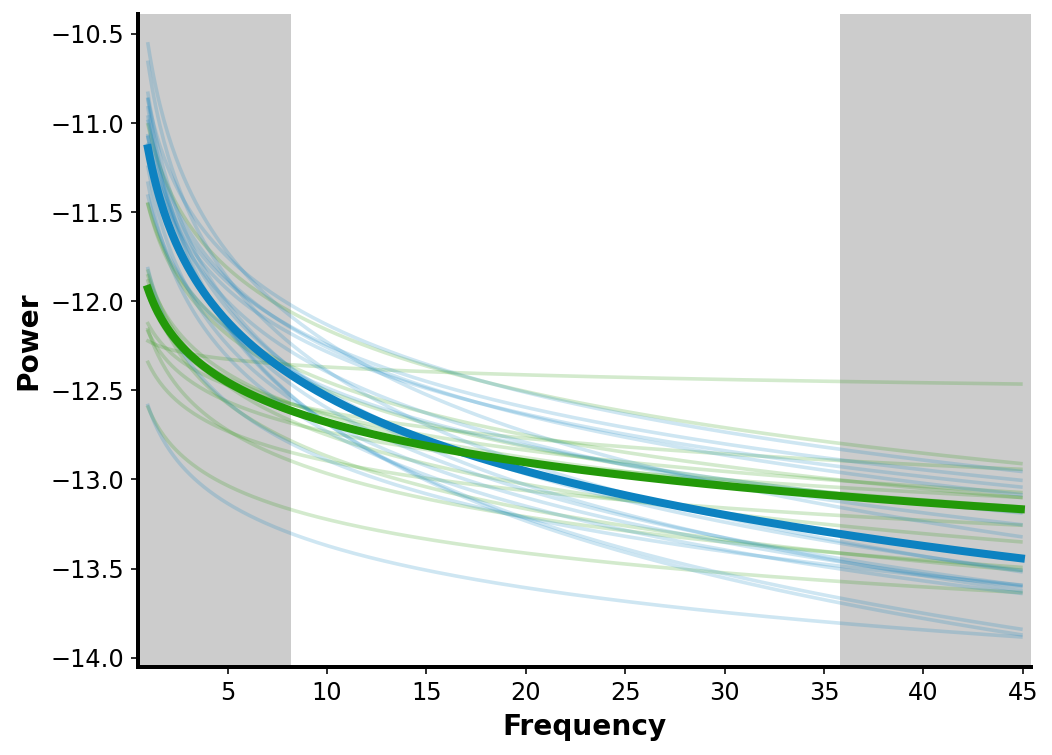

In [51]:
# Plot aperiodic component, comparing the power difference at each frequency
fs, difs, ps = plot_aperiodic(aps, return_vals=True,
                              save_fig=SAVE_FIG, save_name='Aperiodics')

In [52]:
# Check frequencies at which p-value switches
p_switches = fs[np.argwhere(np.diff(np.array(ps) < 0.05))]
print(*p_switches)

[7.6] [36.2]


### Compare 'Peaks' from Aperiodic

Here, we will do the same thing as above, comparing frequency specific differences arising from aperiodic differences, specifically for alpha (10 Hz). 

In [53]:
# Pull out the difference in power, at 10 Hz, arising from aperiodic difference
exp_alphas = []
for ap in aps:
    exp_alphas.append(expo_nk_function(np.array([10]), *ap)[0])
exp_alphas = np.array(exp_alphas)

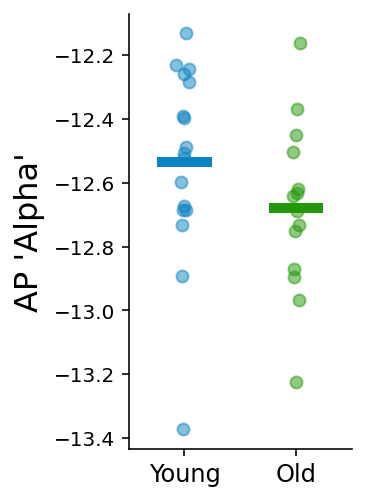

In [54]:
# Compare the 'alpha' difference - coming only from aperiodic differences
plot_comp_scatter(exp_alphas, "AP 'Alpha'",
                  save_fig=SAVE_FIG, save_name='APAlpha')

In [55]:
# Statistically test difference in 'AP-Alpha'
print_stat('AP-Al Diff', *ttest_ind(exp_alphas[YNG_INDS], exp_alphas[OLD_INDS]))

AP-Al Diff: 	  1.3982 	 0.1727


#### Compare across all frequencies

Note: this is an old version of the aperiodic comparison above.

In [56]:
# Calculate aperiodic components of power spectra for each subject
freqs = range(2, 50, 2)
model_aps = []
for ap in aps:
    model_aps.append(expo_nk_function(np.array(freqs), *ap))
model_aps = np.array(model_aps)

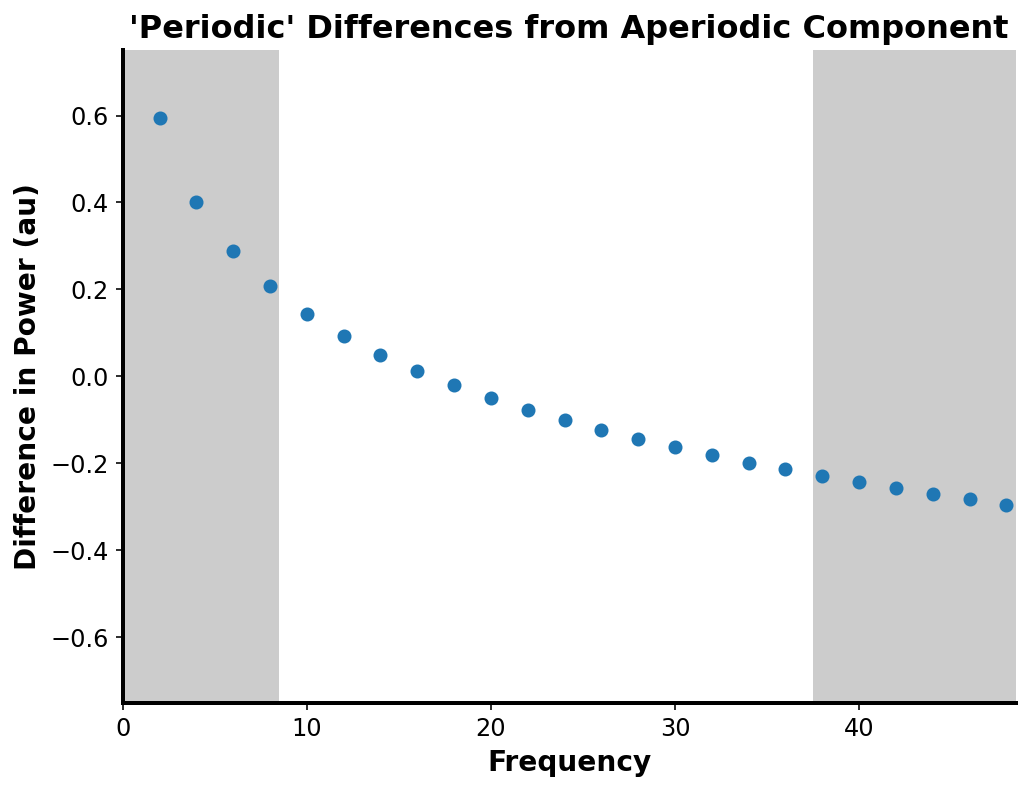

In [57]:
# Calculate average difference per frequency, and plot comparison
avg_diffs, p_vals = calc_ap_comps(freqs, model_aps)
plot_ap_band_diff(freqs, avg_diffs, p_vals)

## Controls - check errors

Check that there isn't a systematic different in model fit error / R^2 between groups that could potentially explain group differences.

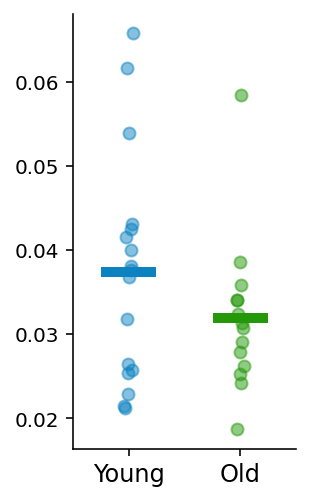

In [58]:
# Compare errors between groups
plot_comp_scatter(errs)

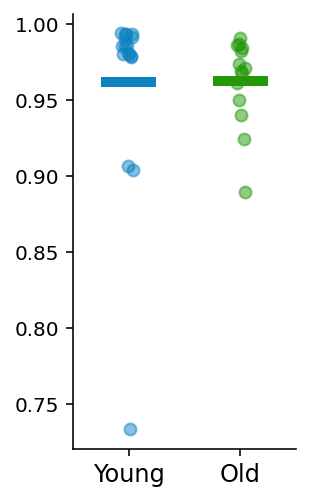

In [59]:
# Compare errors between groups
plot_comp_scatter(r2s)

In [60]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errs[YNG_INDS], errs[OLD_INDS]))
print_stat('R-squared', *ttest_ind(r2s[YNG_INDS], r2s[OLD_INDS]))

Errors: 	  1.2966 	 0.2050
R-squared: 	 -0.0296 	 0.9766


In [61]:
# Check the correlation between errors and R^2s
print_stat('Errs & R2s ', *pearsonr(errs, r2s))

Errs & R2s : 	 -0.6198 	 0.0002


## Correlations between FOOOF Features

In [62]:
# Extract Oz aperiodic parameters
oz_offs = oz_aps[:, 0]
oz_exps = oz_aps[:, 1]

In [63]:
# Correlation between aperiodic features
print_stat('Cz - OFF  &  EXP ', *pearsonr(offs, exps))
print_stat('Oz - OFF  &  EXP ', *pearsonr(oz_offs, oz_exps))

Cz - OFF  &  EXP : 	  0.8869 	 0.0000
Oz - OFF  &  EXP : 	  0.8520 	 0.0000


In [64]:
# Correlations between oscillation features
print_stat('CF  &  PW', *pearsonr(alphas[:, 0], alphas[:, 1]))
print_stat('CF  &  BW ', *pearsonr(alphas[:, 0], alphas[:, 2]))
print_stat('PW  &  BW ', *pearsonr(alphas[:, 1], alphas[:, 2]))

CF  &  PW: 	  0.1667 	 0.3702
CF  &  BW : 	  0.3280 	 0.0716
PW  &  BW : 	 -0.0533 	 0.7757


In [65]:
# Correlations between exponent and oscillation features
print_stat('CF  &  EXP ', *pearsonr(alphas[:, 0], oz_exps))
print_stat('PW  &  EXP ', *pearsonr(alphas[:, 1], oz_exps))
print_stat('BW  &  EXP ', *pearsonr(alphas[:, 2], oz_exps))

CF  &  EXP : 	  0.3915 	 0.0294
PW  &  EXP : 	  0.0908 	 0.6272
BW  &  EXP : 	  0.4618 	 0.0089


In [66]:
# Correlation between FOOOF outputs and error
print_stat('Oz CF  &  Err', *pearsonr(errs, alphas[:, 0]))
print_stat('Oz PW  &  Err', *pearsonr(errs, alphas[:, 1]))
print_stat('Oz BW  &  Err', *pearsonr(errs, alphas[:, 2]))
print_stat('Oz EXP &  Err', *pearsonr(errs, oz_exps))

Oz CF  &  Err: 	 -0.2152 	 0.2450
Oz PW  &  Err: 	  0.3496 	 0.0538
Oz BW  &  Err: 	 -0.2434 	 0.1870
Oz EXP &  Err: 	 -0.2048 	 0.2690


In [67]:
# Correlation between FOOOF outputs and r2s
print_stat('Oz CF  &  R^2', *pearsonr(r2s, alphas[:, 0]))
print_stat('Oz PW  &  R^2', *pearsonr(r2s, alphas[:, 1]))
print_stat('Oz BW  &  R^2', *pearsonr(r2s, alphas[:, 2]))
print_stat('Oz EXP &  R^2', *pearsonr(r2s, oz_exps))

Oz CF  &  R^2: 	  0.3964 	 0.0273
Oz PW  &  R^2: 	  0.2761 	 0.1327
Oz BW  &  R^2: 	  0.3840 	 0.0330
Oz EXP &  R^2: 	  0.5321 	 0.0021
